In [2]:
import fastbook
fastbook.setup_book()

In [4]:
from fastai.vision.all import *
from fastbook import *

In [5]:
# Access MNIST dataset from fastai
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
Path.BASE_PATH = path

In [8]:
# See the directory contents for the MNIST dataset
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [9]:
# See the contents of our train folder - '3' and '7' will be our labels
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [10]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [14]:
# Use Image class from Python Imaging Library (PIL) to open a sample image of 3
im_3_path = threes[1]
im_3 = Image.open(im_3_path)
im_3

To see the numbers that make up this image - we need to cover it to either a *NumPy Array* or a *PyTorch Tensor*.

The `4:10` in the code below represents that we request the rows/columns from index 4 (**inclusive**) to index 10 (**not inclusive**). So this is basically showing the top-left corner of the image since the indices work from top-to-bottom and left-to-right.

In [15]:
# NumPy Array
array(im_3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [16]:
# PyTorch Tensor
tensor(im_3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can now take a look at a larger section of the image and see how these values help represent the number 3.

A few things to note is that this image is 28 x 28 - meaning it has 784 pixels in total. Each pixel has a value from 0-255, where 0 is white and 255 is black. Anything in between is some type of gray.

In [17]:
im_3_tensor = tensor(im_3)
df = pd.DataFrame(im_3_tensor[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Attempt 1: Pixel Similarity

To solve this classification problem, we can start by simply taking the average pixel values of an image that represents that number 3 and the average of the pixel values of an image that represents 7. We can then take the average of the pixels of any image and cross-reference it to these two base points to see if the image represents a 3 or a 7. 

Start by creating a tensor of all of our 3s stacked together - by first creating a plain list of the single image tensors using **Python List Comprehension**.

**Python List Comprehension**: A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

In [18]:
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

len(three_tensors), len(seven_tensors)

(6131, 6265)

Since all of the images are now in tensor format, to display them as images, use fastai's `show_image` function to do so.

<Axes: >

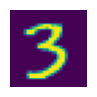

In [22]:
show_image(three_tensors[1])

To get the average value for every pixel across all the images, we need to combine all the images into a single, three-dimensional tensor - **rank 3 tensor**. Individual tensors can be stacked into a collection of tensors using PyTorch's `stack`.

Also, whenever taking the mean in PyTorch, ints need to be converted into floats. This is done using `.float()`. We're not taking the mean right now but we may as well cast the tensor into that type now.

In [24]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

`.shape` tells us that our `stacked_threes` includes 6131 images, each of which are 28x28 pixels.

`len()` of a tensor's `shape` will tell us the tensor rank.

In [25]:
len(stacked_sevens.shape)

3

### Key Jargon to Remember

* **Rank**: The number of axes or dimensions in a tensor - *6131* **(1)**, *28* **(2)**, *28* **(3)**.
* **Shape**: The size of each axis of a tensor - *6131, 28, 28*.
* *The **length** of a tensor's **shape** is its **rank***.

A tensor's rank can be directly found with `ndim`:

In [26]:
stacked_threes.ndim

3

Now, computing the mean or "ideal" 3 & 7 (the one with average pixel values that we'll compare future images to) can be done by calculating the mean along *dimension 0* - the 6131 images.

The image is dark where all the images agree it should be dark and blurry where the images disagree.

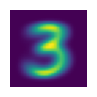

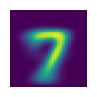

In [29]:
mean_3 = stacked_threes.mean(0)
mean_7 = stacked_sevens.mean(0)

show_image(mean_3), show_image(mean_7);

One of the problems we may encounter with taking the differences between the pixels of the sample image and the ideal image is that some differences will be positive and others will be negative - causing them to cancel out when averaged. 

As a result, there are two key ways of determining the distance a sample image has from our mean/ideal image:

* **Mean Absolute Difference - L1 Norm**: Take the mean of the *absolute value* of differences of the pixels.
* **Root Mean Squared Error (RMSE) - L2 Norm**: Take the mean of the *squared value* of differences of the pixels and then take the *square root* (to undo the squaring).  

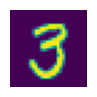

In [31]:
# Sample Image
sample_3 = stacked_threes[2]
show_image(sample_3);

In [33]:
dist_3_abs = (sample_3 - mean_3).abs().mean()
dist_3_sqr = ((sample_3 - mean_3)**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(0.1100), tensor(0.1980))

In [34]:
dist_7_abs = (sample_3 - mean_7).abs().mean()
dist_7_sqr = ((sample_3 - mean_7)**2).mean().sqrt()

dist_7_abs, dist_7_sqr

(tensor(0.1541), tensor(0.2974))

It can be seen that in both cases above (L1 Norm and L2 Norm) that the values are lower against our ideal 3, indicating that the sample image is likely a 3.

Instead of having to manually calculate L1 Norm and L2 Norm, PyTorch provides both of these as **loss functions** inside `torch.nn.functional` - often (and with fastai, automatically) imported as `F`.

* `F.l1_loss()` = mean absolute difference
* `F.mse_loss()` = mean squared error

In [35]:
F.l1_loss(sample_3.float(), mean_7), F.mse_loss(sample_3.float(), mean_7)

(tensor(0.1541), tensor(0.0885))

## Side Notes: NumPy Arrays and PyTorch Tensors

PyTorch tensors are used instead of NumPy arrays in deep learning since the latter does not support using the GPU or calculating gradients.

Below is a summary of important functions and tricks to know for both NumPy and PyTorch:

1. Creating an array or tensor

In [36]:
data = [[1, 2, 3], [4, 5, 6]]

arr = array(data)
tnsr = tensor(data)

arr, tnsr

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

The following operations will be shown only on a PyTorch tensor, but the *syntax is identical* for NumPy arrays.

2. Selecting a row

In [37]:
tnsr[1]

tensor([4, 5, 6])

3. Selecting a column, by using `:` to indicate all of the *first axis* (rows) - in this case, axis refers to the dimension

In [38]:
tnsr[:, 1]

tensor([2, 5])

4. Combine these selections with Python slice syntax - `[start:end]` (where `end` is excluded)

In [44]:
tnsr[1, :3]

tensor([4, 5, 6])

5. Standard operators such as `+`, `-`, `*`, and `/` all work

In [45]:
tnsr+1

tensor([[2, 3, 4],
        [5, 6, 7]])

6. Tensors have a type

In [46]:
tnsr.type()

'torch.LongTensor'

7. The type of a tensor changes automatically from `int` to `float` when needed

In [50]:
tnsr*2.1

tensor([[ 2.1000,  4.2000,  6.3000],
        [ 8.4000, 10.5000, 12.6000]])

## Computing Metrics Using Broadcasting

Back to the original MNIST problem, to know if the baseline model we created is any good we need some metric to measure success. 

We could use MSE or mean absolute error and take the average of them over the whole dataset - but these numbers are difficult to interpret for most. *Accuracy* is a far easier to understand metric for classification models.

Let's test the model on the MNIST validation set (not really necessary because we don't have any trained components but just for the sake of best practice).

In [51]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Now we want to write a function that can test if a number is or is not 3 based on our mean/ideal image.

In [71]:
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2)) # (-1, -2) -> calculate the mean of the last two dimensions of the passed in tensors (the 28, 28 height/width pixels - not # of images)

mnist_distance(sample_3, mean_3)

tensor(0.1100)

Normally, you would have to write some type of loop to compare all the pixel values (28, 28) of all the images in our validation set against our `mean_3` image and see what the loss looks like for each of them. 

However, in PyTorch, you can actually pass in an entire rank-3 tensor into the `mnist_distance` function even though the function looks like it's only meant for comparing two individuals images of the *same size*.

In [63]:
# Clearly, the shapes below don't match (rank-3 vs. rank-2)
valid_3_tens.shape, mean_3.shape

(torch.Size([1010, 28, 28]), torch.Size([28, 28]))

In [62]:
# But the distance calculation still works!
valid_3_dist = is_3(valid_3_tens, mean_3)

valid_3_dist, valid_3_dist.shape

(tensor([0.1358, 0.1117, 0.1361,  ..., 0.1114, 0.1087, 0.1242]),
 torch.Size([1010]))

PyTorch uses **broadcasting** - automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. 

If you look in the `mnist_distance` function, it is apparent that we're only comparing the height/width of images (`.mean(-1, -2)`); but, our validation set has 1010 of these 28x28 images. 

So, what PyTorch is basically doing is expanding our `mean_3` image into a rank-3 tensor (from it's current state as a rank-2 tensor) by treating it as if it were 1010 copies of the single image it is representing. This allows for to be subtracted from each image in the `valid_3_tens` tensor. 

Taking a look at the shape of the tensor during subtraction between `valid_3_tens` and `mean_3`, we can clearly see the effect of **broadcasting**.

In [70]:
(valid_3_tens - mean_3).shape

torch.Size([1010, 28, 28])

A few important points of **broadcasting**:

* Does not actually copy `mean_3` 1010 times - it just *pretends* it's a tensor of that shape without allocating additional memory
* Entire calculation happens in C (or, if using a GPU, in does the entire calculation in CUDA - the equivalent of C on the GPU) which is more than 10,000x faster (>1,000,000x on GPU)

The `.abs` in our function is an elementwise operation (just like `+` or `-` on a tensor) so we get 1010 matrices of absolute values. Then, as explained, we use `mean((-1, -2))` on these 1010 matrices to get the mean of the horizontal and vertical dimensions of our image. 

We can define a function to validate if an image is the digit 3 by using the rule that if the distance to the ideal 3 is less than the distance to the ideal 7, then the image is a 3.

In [72]:
def is_3(x): return mnist_distance(x, mean_3) < mnist_distance(x, mean_7)

# Show True and 1.0 (which means True)
is_3(sample_3), is_3(sample_3).float()

(tensor(True), tensor(1.))

In [73]:
# Test on entire validation set for 3s
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [76]:
# Create an accuracy for 3s and 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

In [77]:
# Collective accuracy
(accuracy_3s + accuracy_7s) / 2

tensor(0.9511)

This model, which has no training, is getting around a collective accuracy of 95%!

However, we're only testing it on differentiating between 3s and 7s, which is not a very hard task since they're extremely different numbers. 

We want a system that can actually **learn** - automatically modify itself to improve its performance.

## Stochastic Gradient Descent (SGD)